# Download and Mosaic Multiple 3DEP DTM Tiles

This code is adapted (by Hannah Besso) from David Shean's geospatial_cookbook_rendered.ipynb notebook created for UW's SnowEx Hackweek 2021

### This notebook does the following:
* Read in a list of urls linking to individual 3DEP tiles that cover Grand Mesa
* Downloads, reprojects, and mosaics the tiles using gdal
* Clips the mosaic'd image to the flat top of Grand Mesa

In [17]:
# Import necessary packages

import os
import rasterio as rio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona

### Open the text file listing urls of all the tiles intersecting Grand Mesa

In [2]:
url_fn_3DEP = 'gm_3dep_1m_lidar_tiles.txt'

In [3]:
with open(url_fn_3DEP) as f:
    url_list = f.read().splitlines()

In [4]:
url_list.sort()

In [5]:
path_list = []
for url in url_list:
    path = f'/vsicurl/{url}'
    path_list.append(path)
path_list_str = ' '.join(path_list)

In [6]:
url = open("url_list.txt", "w")

for element in url_list:

    url.write(element + "\n")

url.close()

In [7]:
vrt_fn = os.path.splitext(url_fn_3DEP)[0]+'.vrt'
tif_fn = os.path.splitext(url_fn_3DEP)[0]+'.tif'

### Build a Virtual Dataset using GDAL and the list of urls
https://gdal.org/programs/gdalbuildvrt.html 

In [8]:
#This actually takes some time as file must be downloaded and unzipped to read img header
!gdalbuildvrt -quiet $vrt_fn $path_list_str

Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone 12N. Skipping /vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x73y431_CO_MesaCo_QL2_UTM12_2016.tif
Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone 12N. Skipping /vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x73y432_CO_MesaCo_QL2_UTM12_2016.tif
Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone 12N. Skipping /vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x73y433_CO_MesaCo_QL2_UTM12_2016.tif
Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone

In [9]:
# Set the destination crs to UTM Zone 12N

dst_crs = 'EPSG:32612'

### Download, Reproject, and Mosaic the 3DEP Tiles
https://gdal.org/programs/gdalwarp.html

In [10]:
#Since these tiles are mixed projection, can download, reproject and mosaic in one go
!gdalwarp -q -r cubic -tr 3.0 3.0 -dstnodata -9999 -t_srs $dst_crs \
-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER \
$path_list_str $tif_fn

ERROR 1: Output dataset gm_3dep_1m_lidar_tiles.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



### Upload the Mosaic'd File and Clip to GM Flat Top

In [14]:
# Open the new .tif file containing the mosaic'd DTMs

src = rio.open('/home/jovyan/space_lasers/notebooks/gm_3dep_1m_lidar_tiles.tif')

In [15]:
# Inspect the file, confirming that the crs is 32612 (UTM Zone 12N)

src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 5070, 'height': 3264, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(3.0, 0.0, 737688.5474426108,
       0.0, -3.0, 4330434.375353689), 'tiled': False, 'interleave': 'band'}

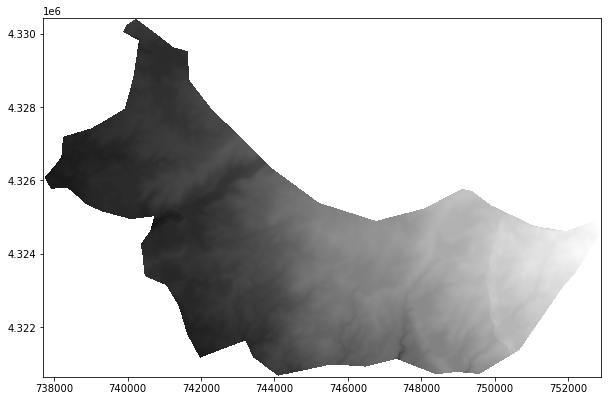

<AxesSubplot:>

In [20]:
# Plot the mosaic'd file

fig, ax = plt.subplots(figsize=(10,10))
rio.plot.show(src, cmap='gray')

In [13]:
# Load in a polygon of the flat top of the Mesa 
# Can create a polygon of a different section using:
# https://geojson.io/

poly_fn = '/home/jovyan/space_lasers/notebooks/map.geojson'
gm_poly = gpd.read_file(poly_fn)

**Check the CRS of the polygon. If it does not match that of the .tif file, complete the following steps to reproject:**

In [5]:
gm_poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Reproject the polygon so that it matches the crs of the 3DEP .tif file

gm_poly = gm_poly.to_crs(crs=dst_crs)

In [7]:
# Save the reprojected polygon:

gm_poly.to_file("/home/jovyan/space_lasers/notebooks/GM_tight_poly_32612.geojson", driver='GeoJSON')

In [20]:
# Define the file path to the new projected polygon, and the mosaic'd tif output in earlier steps:

poly_fn = "/home/jovyan/space_lasers/notebooks/GM_tight_poly_32612.geojson"
tif_fn = '/home/jovyan/space_lasers/notebooks/gm_3dep_1m_lidar_tiles.tif'

**Clip the .tif using the polygon:**

In [21]:
# Open the polygon using fiona and make a list of features in the polygon (in this case the list will contain one feature)

with fiona.open(poly_fn, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [11]:
with rio.open(tif_fn) as src:
    out_image, out_transform = rio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [12]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(tif_fn, "w", **out_meta) as dest:
    dest.write(out_image)

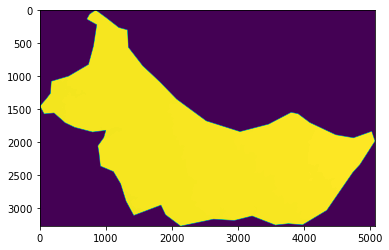

<AxesSubplot:>

In [13]:
rio.plot.show(out_image)